<a href="https://colab.research.google.com/github/Nguyen-The-Thanh/NguyenTheThanh_training_FMlab/blob/main/Ex/Ex11/convolutional_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Bài tâp về mạng tích chập

Trong bài này, chúng ta sẽ xây dựng một mạng tích chập sử dụng torch và thử train&test với tập MNIST nhé.


## Tổng quan một mạng CNN cơ bản

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST dataset

Trong bài tập này, chúng ta sẽ sử dựng tập MNIST rất nổi tiếng vể  các chữ số viết tay từ 0->9. Tập dataset này bao gồm 60000 ảnh cho training và 10000 ảnh cho testing. Các bức ảnh này đều đã được căn giữa và chỉnh với kích thước cố định là 28x28.

Trong phần tiền xử lý, chúng ta sẽ cần chuẩn hóa các giá trị pixel của mỗi ảnh về khoảng [0,1], kiểu dữ liệu sẽ là float32

<!-- ![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png) -->

Chi tiết tại: http://yann.lecun.com/exdb/mnist/

# Some configs

- Chúng ta sẽ setup một số hyper-parameters cũng như một số giá trị cần dùng theo hướng dẫn nhé
- Ở đây, mình muốn các bạn sử dụng Cuda, hãy vào runtime, rồi change the runtime type sang GPU nhé

In [27]:
# Trước hết, chúng ta import một số thư viện cần thiết đã
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [28]:
# Số classes trong tập MNIST
num_classes = 10

# Số epoch
epochs = 2

# Các tham số cần thiết cho quá trình traning.
learning_rate = 0.001
batch_size = 128
display_step = 50

# Path lưu best model
checkpoint = 'model.pth' # có thể để dạng *.pth

# device chúng ta dùng cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert device == 'cuda'

# Dataloader


In [29]:
# Transform image
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# load dataset từ torchvision.datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST('../data', train=False,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128)

# Model

- Trong bài này, chúng ta sẽ định nghĩa một class Net, nó sẽ có cấu trúc như hình ở đầu notebook
- Bạn hãy chỉnh các tham số cho phù hợp nhé :)

In [30]:
class Net(nn.Module):
  def __init__(self):

    super(Net,self).__init__()
    self.dropout = nn.Dropout()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(1,32,3,1)
    self.maxpool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32,64,3,1)
    self.maxpool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64,64,3,1)
    self.maxpool3 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(64, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, num_classes)

  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool2(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool3(x)
    x = self.dropout(x)
    x = nn.Flatten()(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc3(x)# bạn hãy xem xet quá trình forward nhé
    return x

In [31]:
# call model
model = Net().to(device)

# load lại pretrained model (nếu có)
try:
  model.load_state_dict(torch.load(checkpoint))
except:
  print("!!! Hãy train để có checkpoint file")

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val_loss = 999

for epoch in range(1,epochs):
    # Quá trình training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # Add this line to move data to GPU
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % display_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    # Quá trình testing
    model.eval()
    test_loss = 0
    correct = 0
    # set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) # Add this line to move data to GPU
            output = model(data)
            output = F.log_softmax(output,dim=1) # log softmax using F, chu y dim
            test_loss += criterion(output,target)
            pred = output.argmax(dim = 1,keepdim = True) # argmax để lấy predicted label, chú ý keepdim = True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model.state_dict(), checkpoint)  # Lưu lại model
      print("***********    TEST_ACC = {}%    ***********".format(correct))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.621141
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.740689
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.680677
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.480418
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.703485
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.598640
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.671084
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.559981
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.616655
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.657068
***********    TEST_ACC = 9636%    ***********


In [33]:
# load lại model đã train
model.load_state_dict(torch.load(checkpoint))
# set eval phase
model.eval()

Net(
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [34]:
item = iter(test_loader)

In [35]:
data,target = item.__next__() # lấy một batch ra

In [36]:
test_idx = random.choice(range(len(data))) # lấy index của một phần tử của một batch

In [37]:
data = data[test_idx]
target = target[test_idx]
assert data.shape == (1,28,28)

In [40]:
# thử predict

def plot(data,model):
  data = torch.unsqueeze(data,dim=0) # unsqueeze data
  data = data.to(model.conv1.weight.device) # Move data to the same device as the model
  output = model(data)
  output = F.log_softmax(output,dim=1) # log softmax, chú ý dim
  pred = output.argmax(dim=1,keepdim=True) # argmax, chú ý keepdim
  print("Predict Number : ", pred[0][0].cpu().numpy()) # Move to CPU before converting to NumPy
  plt.imshow(data[0][0].cpu(),cmap='gray') # Move data back to CPU for plotting
  plt.show()

Predict Number :  6


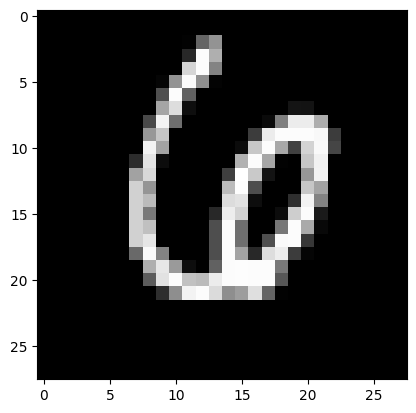

In [41]:
plot(data,model)